# Setup: Create Data

In [1]:
# from src.cone_model import HEALPixCone

# data_NSIDE = 32

# cone_model = HEALPixCone(
#         output_dir=os.path.join("", 'figs'),
#         NSIDE=data_NSIDE
# )

# train_dset = cone_model.create_dataset(dataset_size=1024)
# val_dset = cone_model.create_dataset(dataset_size=1024)   
# f = open(f"sphere_datasets_NSIDE{config.NSIDE}.pkl", "wb"); pickle.dump((train_dset, val_dset), f); f.close()

# Set Important Parameters

In [2]:
NSIDE = 8
NUMPIX = 12 * NSIDE ** 2
DEPTH = 4
SHOW_IMAGES = True

# Helper Functions

In [3]:
from torchvision.utils import save_image
import os
import torch

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device


def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 12 * NSIDE // 8, 64 * NSIDE // 8)
    save_image(img, name)

/Users/akotamraju/opt/anaconda3/envs/nn_response/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set Device.

In [4]:
device = get_device()
base = torch.float32

#pin to gpu
device

'cpu'

Set Seed for Pytorch

In [5]:
from src.utils import set_seed
set_seed(2021)

# 1. Load in Data

In [6]:
'''
Open the file.
'''

import pickle
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

file_name = f"sphere_datasets_NSIDE{NSIDE}.pkl"

f = open(file_name, "rb")
train_dset, val_dset = pickle.load(f)
f.close()

test = np.array(train_dset)

print(len(train_dset), len(val_dset))

1024 1024


# 2. Reshape Data into Rectangles

In [7]:
'''

Create the training and validation datasets. Do any necessary reshaping. 

'''

import numpy as np


y_combined = []

# NOTE: Can change based on input size of data
# For now, default to 12, 64 size for NSIDE 8 that is scaled up for larger NSIDEs. 
length = 64 * NSIDE // 8
width = 12 * NSIDE // 8
rect_shape = (1, width, length)

NUM_CHANNELS = 1

for i in range(len(train_dset)):
    all_train_depths = train_dset[i]['label'].reshape(NUM_CHANNELS, DEPTH, NUMPIX)
    all_val_depths = val_dset[i]['label'].reshape(NUM_CHANNELS, DEPTH, NUMPIX)

    # [0] just so you can get inside the list (only one channel)
    for j in range(4):
        y_combined.append(all_train_depths[0][j].reshape(rect_shape))
        y_combined.append(all_val_depths[0][j].reshape(rect_shape))

y_combined = np.array(y_combined)

print("y_combined shape: ", y_combined.shape)



y_combined shape:  (8192, 1, 12, 64)


# 3. Split Data into Train, Val, Test

In [8]:
train_len = int(0.7 * len(y_combined)) # 70%
val_len = int(0.15 * len(y_combined)) # 15%
test_len = len(y_combined) - train_len - val_len # 15%

y_train = y_combined[:train_len]
y_val = y_combined[train_len : train_len + val_len]
y_test = y_combined[train_len + val_len:]

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (5734, 1, 12, 64)
y_val shape:  (1228, 1, 12, 64)
y_test shape:  (1230, 1, 12, 64)


# 3. Create Noisy Versions of Data

In [9]:
mu, sigma = 0, 0.3 # mu is the mean, sigma is the standard deviation of the noise distribution

x_combined = []

noise_shape = rect_shape

for y_sample in y_combined:
    # Create array of noise of how many pixels there are
    noise = np.random.normal(mu, sigma, noise_shape)

    x_combined.append(y_sample + noise)

x_combined = np.array(x_combined)

print("x_combined shape: ", x_combined.shape)


x_combined shape:  (8192, 1, 12, 64)


# 4. Create Test, Val, and Train

In [10]:
train_len = int(0.8 * len(y_combined)) # 70%
val_len = int(0.15 * len(y_combined)) - train_len # 15%
test_len = len(y_combined) - train_len - val_len # 15%

y_train = y_combined[:train_len]
y_val = y_combined[:val_len]
y_test = y_combined[:test_len]

x_train = x_combined[:train_len]
x_val = x_combined[:val_len]
x_test = x_combined[:test_len]

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)
print()
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)

y_train shape:  (6553, 1, 12, 64)
y_val shape:  (2867, 1, 12, 64)
y_test shape:  (6964, 1, 12, 64)

x_train shape:  (6553, 1, 12, 64)
x_val shape:  (2867, 1, 12, 64)
x_test shape:  (6964, 1, 12, 64)


### Print sample of the noisy healpix data vs. actual data.

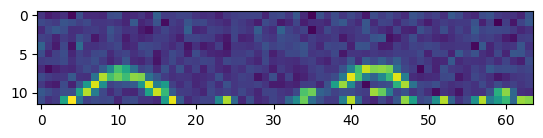

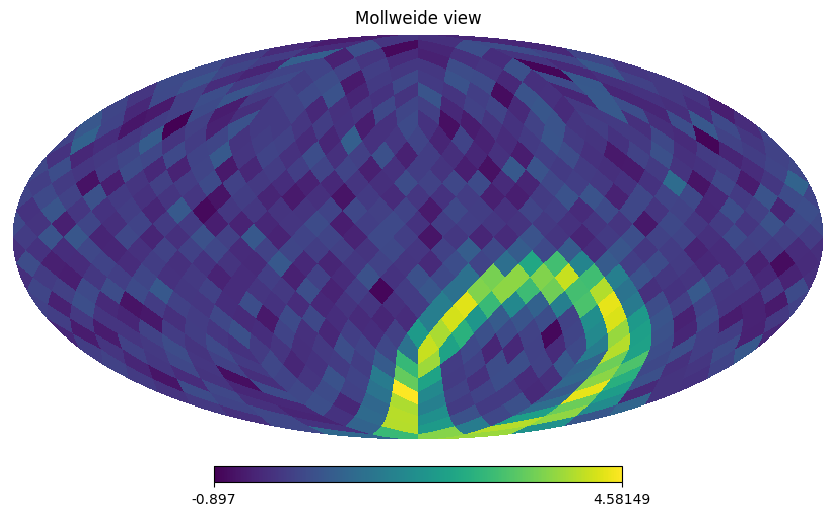

In [11]:
NUM = 333

# [0] since 1 channel
sample_x = x_train[NUM][0]
sample_y = y_train[NUM][0]

if SHOW_IMAGES:
    plt.imshow(sample_x)
    hp.mollview(sample_x.reshape(NUMPIX))


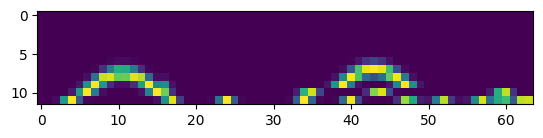

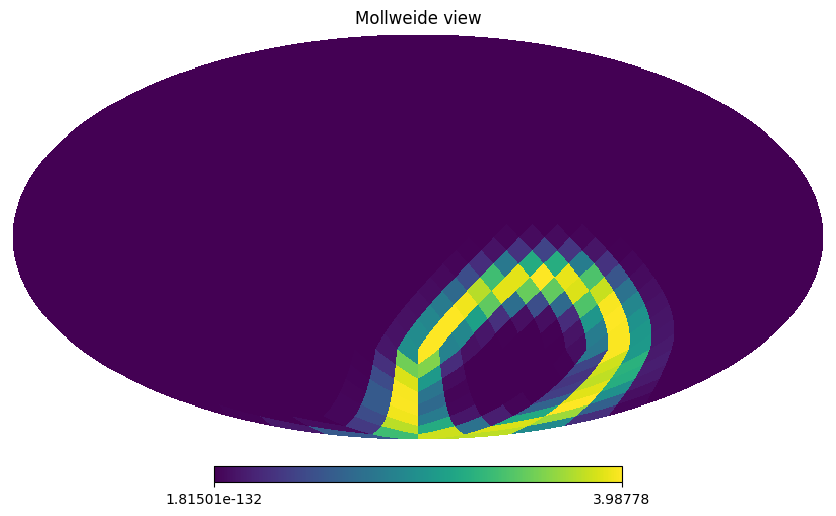

In [12]:
if SHOW_IMAGES:
    plt.imshow(sample_y, interpolation='nearest')
    hp.mollview(sample_y.reshape(NUMPIX))

# 5. Create Dataset and DataLoader

Dataset is wrapper for data with labels, DataLoader is wrapper around that in iterable form.

In [13]:
# constants
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 16 # previously 1
NOISE_FACTOR = 0.5

In [14]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# class GammaDataset(Dataset):
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y

#     def __len__(self):
#         return len(self.x)
    
#     def __getitem__(self, index):
#         return self.x[index], self.y[index]

# train_set = GammaDataset(x_train.to, y_train)
# val_set = GammaDataset(x_val, y_val)
# test_set = GammaDataset(x_test, y_test)

# the "to(torch.float32) is to make it compatible with cpu. We want base 32."

train_set = TensorDataset(torch.tensor(x_train).to(dtype=base, device=device), torch.tensor(y_train).to(dtype=base, device=device))
val_set = TensorDataset(torch.tensor(x_val).to(dtype=base, device=device), torch.tensor(y_val).to(dtype=base, device=device))
test_set = TensorDataset(torch.tensor(x_test).to(dtype=base, device=device), torch.tensor(y_test).to(dtype=base, device=device))

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=True)

Verify the arrays are of the right type (base 32).

In [15]:
# for val in train_loader:
#     tens = val[0]
#     print(tens.dtype)

el = train_set[0][0][0]
el.dtype

torch.float32

# 6. Create Autoencoder

In [16]:
from torch.nn import Module, Conv2d, Sequential, ConvTranspose2d, ReLU, MaxPool2d


'''

IMPORTANT: out_channels is how many filters will be learned for that layer in training
--> the feature map for that layer (3D thing of what the layer outputs) is the stack of these channels (filters) 

'''


class AutoEncoder(Module): 
    def __init__(self, IN_CHANNELS, encoder, decoder):
        super().__init__()

        # Put encoder layers in Sequential container
        # First increase from 1 --> 64 channels
        # Keep decreasing number of channels
        
        self.encoder = encoder

        self.decoder = decoder

    # Run x through each layer
    def forward(self, x):
        for layer in self.encoder:
            # print(x.shape)
            x = layer(x)
        
        # print()
        
        for layer in self.decoder:
            # print(x.shape)
            x = layer(x)
        
        return x
        

In [17]:
IN_CHANNELS = NUM_CHANNELS # Not RGB, just one value for each pixel. Healpy just adds color by itself. 


model8_enc = Sequential(
           Conv2d(IN_CHANNELS, 64, kernel_size=3, padding=1),
           ReLU(),
           Conv2d(64, 32, kernel_size=3, padding=1),
           ReLU(),
           Conv2d(32, 16, kernel_size=3, padding=1),
           ReLU(),
           Conv2d(16, 8, kernel_size=3, padding=1),
           ReLU(),
           MaxPool2d(2, 2),
   )

model8_dec = Sequential(
           ConvTranspose2d(8, 16, kernel_size=1, stride=1),
           ReLU(),
           ConvTranspose2d(16, 32, kernel_size=1, stride=1),
           ReLU(),
           ConvTranspose2d(32, 64, kernel_size=1, stride=1),
           ReLU(),
           ConvTranspose2d(64, 1, kernel_size=2, stride=2),
           ReLU()
   )

# model8_enc = Sequential(
#             Conv2d(IN_CHANNELS, 16, kernel_size=3, padding=1),
#             ReLU(),
#             Conv2d(16, 32, kernel_size=3, padding=1),
#             ReLU(),
#             MaxPool2d(2, 2),
#             Conv2d(32, 64, kernel_size=3, padding=1),
#             ReLU(),
#     )

# model8_dec = Sequential(
#             ConvTranspose2d(64, 32, kernel_size=2, stride=2),
#             ReLU(),
#             ConvTranspose2d(32, 16, kernel_size=1, stride=1),
#             ReLU(),
#             ConvTranspose2d(16, 1, kernel_size=1, stride=1),
#             ReLU()
#     )

# model for NSIDE=8
model8 = AutoEncoder(IN_CHANNELS, model8_enc, model8_dec).to(dtype=base, device=device)
print(model8)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
)


In [18]:
IN_CHANNELS = 1 # Not RGB, just one value for each pixel. Healpy just adds color by itself. 

model32_enc = Sequential(
            Conv2d(IN_CHANNELS, 64, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(64, 32, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(32, 16, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(16, 8, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2, 2),
    )

model32_dec = Sequential(
            ConvTranspose2d(8, 16, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(16, 32, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(32, 64, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            ReLU()
    )

# model for NSIDE=8
model32 = AutoEncoder(IN_CHANNELS, model32_enc, model32_dec).to(dtype=base, device=device)
print(model32)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
)


Pick which model to use.

In [19]:
model = model8

# 7. Create Trainer

In [20]:
import torch.optim as optim
from torch.nn import MSELoss

# Use MSE Loss
# need to specify cpu
criterion = MSELoss().to(dtype=base, device=device)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
# Function to evaluate performance of model on some data
def eval_performance(model, data_loader):
    # Set model to evaluation mode to conserve memory 
    model.eval()

    # Don't want to waste memory on gradients
    with torch.no_grad():
        total_loss = 0.0
        for x, y in data_loader:
            pred = model(x)

            total_loss += criterion(pred, y)
            
        
        # Revert back to train mode
        model.train()

        return total_loss / len(data_loader)

In [22]:


train_loss_hist = []
val_loss_hist = []
epoch = 0

def train(model, train_loader, NUM_EPOCHS):
    global train_loss_hist
    global val_loss_hist
    global epoch

    while epoch < NUM_EPOCHS:
        running_loss = 0.0

        # Go through each batch of the data (can pass in entire batch at once!)
        # batch - number of training examples for one forward/backward pass. So pass in batch data values then update weights. 
        for x_vals, y_vals in train_loader:
            torch.cuda.empty_cache()

            # Remember, it's in batches. 
            
            '''

            Reset gradients to 0 so updating of weights can be done correctly.

            When we do loss.backward(), gradients are calculated. Then, optimizer.step() does gradient descent.
            For the next batch, we don't want these gradients to still be lingering (because a new input will have new gradients).
            Thus, we have to reset the gradients to 0. 

            NOTE: This is not the same as setting the weights to 0! We are just resetting the calculated gradients.
            
            '''
            optimizer.zero_grad()

            # Calculate model outputs
            outputs = model(x_vals)

            # Calculate loss
            loss = criterion(outputs, y_vals)

            # Calculate gradients 
            loss.backward()

            # Do gradient descent to update the weights.
            optimizer.step()

            running_loss += loss.item()


        loss = running_loss / len(train_loader)
        train_loss_hist.append(loss)

        torch.cuda.empty_cache()


        # running_val_loss = 0.0
        # # Calculate val loss
        # for x, y in val_loader:
        #     optimizer.zero_grad()
            
            
        #     # Calculate model outputs
        #     val_outputs = model(x)

        #     loss = criterion(val_outputs, y)
        #     running_val_loss += loss

        val_loss = eval_performance(model, val_loader)
        val_loss_hist.append(val_loss)


        print(f'Epoch {epoch + 1} of {NUM_EPOCHS}, Train Loss: {loss}, Val Loss: {val_loss}')
        # print(f'Epoch {epoch + 1} of {NUM_EPOCHS}, Train Loss: {loss}')

        # Saving a full batch!
        if epoch % 2 == 0:
            save_decoded_image(x_vals.cpu().data, name='./Saved_Images/noisy_batch_{}.png'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='./Saved_Images/denoised_batch_{}.png'.format(epoch))
        
        epoch += 1

# Train Model

In [23]:
train(model, train_loader, NUM_EPOCHS)

Epoch 1 of 20, Train Loss: 0.08098869926591472, Val Loss: 0.022782281041145325
Epoch 2 of 20, Train Loss: 0.019787855216915288, Val Loss: 0.01706337183713913
Epoch 3 of 20, Train Loss: 0.01535061982846478, Val Loss: 0.013926847837865353
Epoch 4 of 20, Train Loss: 0.013236502378542975, Val Loss: 0.012464381754398346
Epoch 5 of 20, Train Loss: 0.011850713105963135, Val Loss: 0.01181410439312458
Epoch 6 of 20, Train Loss: 0.010906939985366857, Val Loss: 0.010989359579980373
Epoch 7 of 20, Train Loss: 0.010319379589906552, Val Loss: 0.009799625724554062
Epoch 8 of 20, Train Loss: 0.009861000358104343, Val Loss: 0.010289008729159832
Epoch 9 of 20, Train Loss: 0.009589529073819882, Val Loss: 0.009191014803946018
Epoch 10 of 20, Train Loss: 0.009190228931242373, Val Loss: 0.008859412744641304
Epoch 11 of 20, Train Loss: 0.009024108945187636, Val Loss: 0.008640775457024574
Epoch 12 of 20, Train Loss: 0.008857172798001911, Val Loss: 0.008408387191593647
Epoch 13 of 20, Train Loss: 0.00861946125

# Save loss graphs.

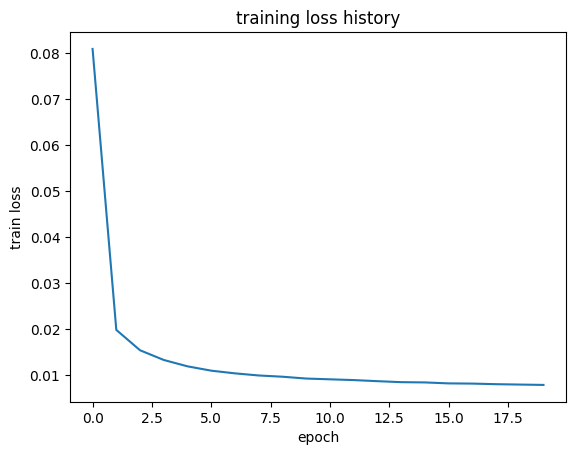

In [24]:
plt.title("training loss history")
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.plot(train_loss_hist)
plt.savefig("train-loss-hist")

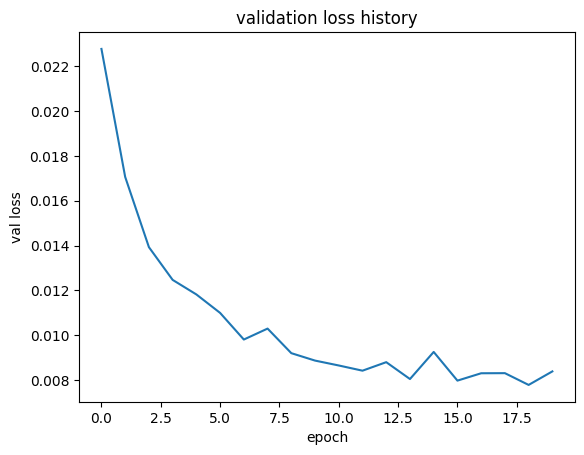

In [25]:
plt.title("validation loss history")
plt.xlabel("epoch")
plt.ylabel("val loss")
plt.plot(val_loss_hist)
plt.savefig("val-loss-hist")

# Check Performance on Validation Set

In [26]:



print(eval_performance(model, val_loader))


tensor(0.0084)


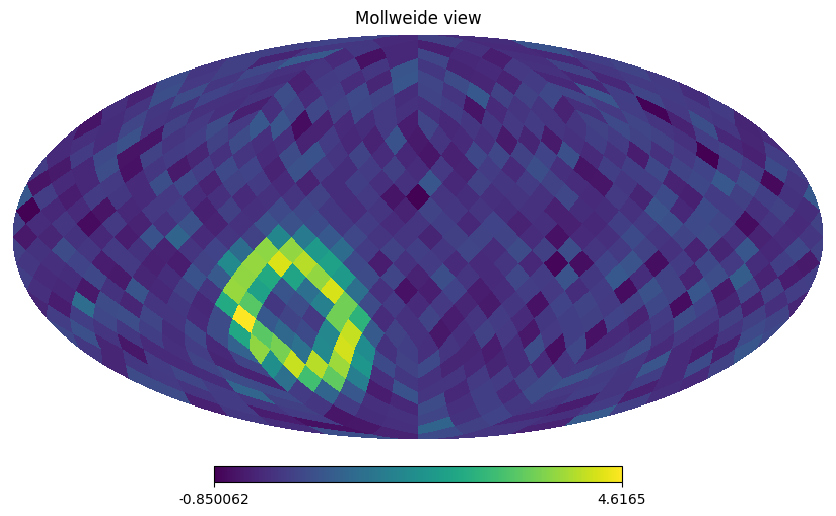

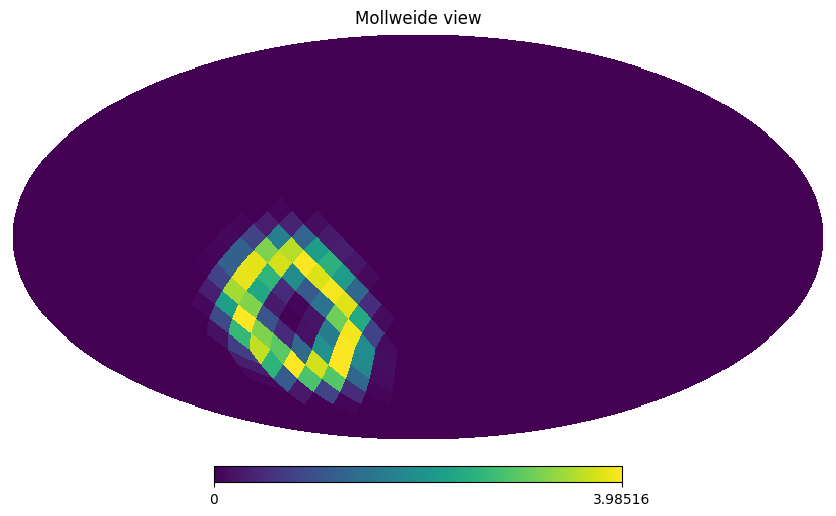

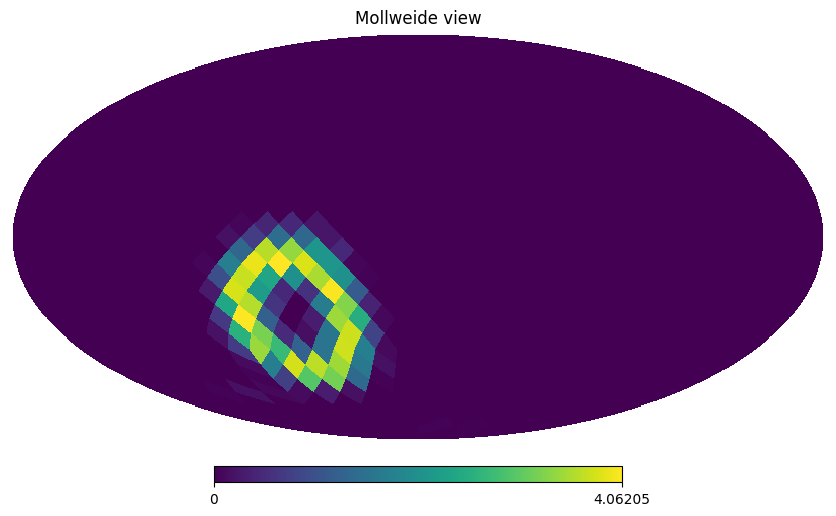

In [32]:

def display_sample(model, data_loader):
    for x, y in data_loader:
        # Set model to evaluation mode to conserve memory 
        model.eval()

        # Don't want to waste memory on gradients
        with torch.no_grad():

            pred = model(x)
            
            # [0] because 1 channel so need to go inside
            hp.mollview(torch.reshape(x[0], (NUMPIX, )))
            hp.mollview(torch.reshape(y[0], (NUMPIX, )))
            hp.mollview(np.reshape(pred[0].detach().numpy(), (NUMPIX, )))

            # set back to train mode
            model.train()
            break
    
if SHOW_IMAGES:
    display_sample(model, val_loader)

# Save Model

In [28]:
final_train_loss = round(float(train_loss_hist[-1]), 3)
final_val_loss = round(float(val_loss_hist[-1]), 3)

name = f"saved_models/model_NSIDE{NSIDE}_trainloss{final_train_loss}_valloss{final_val_loss}_epochs{epoch}.pth"

torch.save(model.state_dict(), name)

# Optional Loading of Past Model and Evaluating


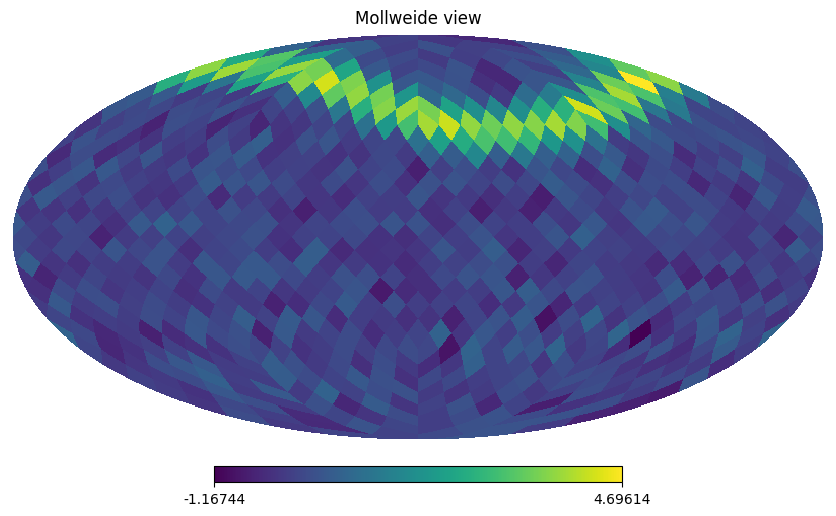

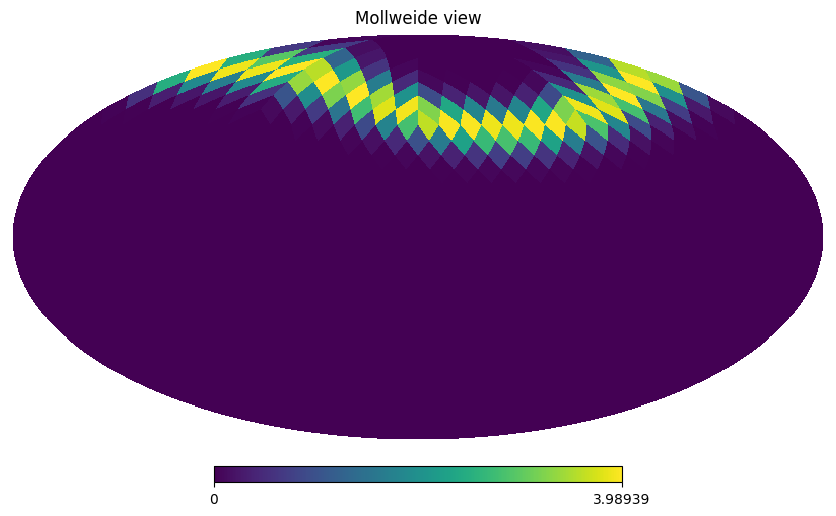

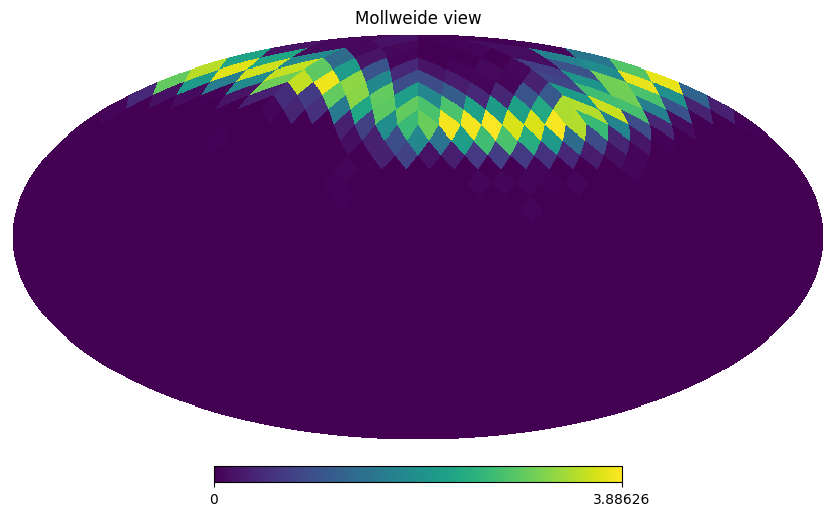

In [29]:
path = '/Users/akotamraju/Documents/savio-files/saved-models/model_NSIDE32_trainloss0.003_valloss0.003_epochs20.pth'
# load just loads in the parameters. Need to have prior model architecture when using state_dict to save.

new_model = model32
dataset_32 = val_loader

# need to specify to convert from/to gpu if needed 
new_model.load_state_dict(torch.load(path, map_location=device))

if SHOW_IMAGES:
    display_sample(new_model, dataset_32)